<h1 style="background-color:yellow; "> Table of Contents</h1> <a class="anchor" id="table-of-content"></a>
    
* [1. Problem Background & Motivation](#problem-background)
* [2. Library Importation](#import-package)
* [3. Custom Libraries](#custom-libraries)
* [4. Connect to Data Source and Data Extraction](#data-extraction)
* [5. Exploratory Data Analysis](#data-prep)
* [6. Machine Learning Model](#ml-model)
* [8. Conclusion and Recommendations](#Conclusion)


<h1 style="background-color:powderblue; ">1. Problem Background and Motivation</h1> <a class="anchor" id="problem-background"></a>

<h3> Hotel Booking cancellation prediction </h3>

<h2> 1.1 General Info </h2>
Hotel Industry is evergrowing in different dimensions providing customers with all the necessary and luxury amenities. One of the main source of revenue is from their rooms getting booked online. It is a major contributor and an important factor of hotel management. 

<img src="https://clark.com/wp-content/uploads/2018/07/hotelbooking.jpg" alt="Hotel Booking" />

 
 
 
<h2> 1.2 What is the problem? </h2>
 
 It seems that online bookings, particularly via online travel agencies (OTAs) like Booking.com, Expedia, Traveloka, and Agoda, have made it so much easier and cheaper for anyone to book a hotel room and cancel when the need arises (and even rebook if they find a cheaper deal for the same room). 
 
Cancellations can have a bad effect on the hotels involved. A loss of income occurs as a result of unsold rooms and no-shows. A no-show is a cancellation without notice. It’s like getting stood up by your date who doesn’t give a rain check, except that the tragedy from this is not just your hurt feelings but also your lost sales income. 

Hence, this is a major problem for the hotel Industry


<h2> 1.3 Interested Party and Reason </h2>

The Hotel Management is the interested party in this problem as they are the one's to benefit if they could get to know before hand if a customer will cancel the booking or not.


 Advantages of having a ML model with Hotel Cancellation prediction powers:
  >- The Hotel managers will have a pretty good idea who will cancel their bookings or not.
  >- Based on the cancellation  prediction, the Hotel can take appropriate actions to reduce their cost/revenue.
  >- The model maybe used to evaluate an hotel's performance like  how many times a booking got cancelled? - This can be used to get to the root cause of why the cancellations are happening.


* [Go to Top](#table-of-content) 

<h1 style="background-color:powderblue; ">2. Library Importation</h1> <a class="anchor" id="import-package"></a>
  
  Import the required packages needed for the model.
  

In [137]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import pickle

# Graphics
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# ML
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#New Libraries for sampling and feature selection
from feature_engine.imputation import MeanMedianImputer
from feature_engine.selection import RecursiveFeatureElimination
from imblearn.under_sampling import NearMiss

#To represent world maps
import folium
from folium.plugins import HeatMap
import plotly.express as px

#extra ML models
import time
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier


<h1 style ="background-color:powderblue;"> 3. Custom Built Libraries</h1> <a class="anchor" id="custom-libraries"> </a>

In [138]:
# Custom function below is used to display performance measures
# Required inputs are the model name and the two test data objects (X,y)
def class_perf_measures(model,X_test,y_test):
    # Create empty lists to store metric values created within loop
    TP = []
    TN = []
    FP = []
    FN = []
    recall = []
    precision = []
    F1 = []
    Accuracy = []
    
    # Create list of probability threshold values to loop over
    threshold = np.arange(0,1.1,0.1).tolist()

    # Start loop
    for i in threshold:

        # Create class assignments given threshold value
        y_test_pred_class = (model.predict_proba(X_test)[:,1] >= i).astype(int)

        # Append lists with metric values
        TP.append(metrics.confusion_matrix(y_test, y_test_pred_class)[1,1])
        TN.append(metrics.confusion_matrix(y_test, y_test_pred_class)[0,0])
        FP.append(metrics.confusion_matrix(y_test, y_test_pred_class)[0,1])
        FN.append(metrics.confusion_matrix(y_test, y_test_pred_class)[1,0])
        recall.append(metrics.recall_score(y_test, y_test_pred_class).round(3))
        precision.append(metrics.precision_score(y_test, y_test_pred_class).round(3))
        F1.append(metrics.f1_score(y_test, y_test_pred_class).round(2))
        Accuracy.append(metrics.accuracy_score(y_test, y_test_pred_class).round(2))

    # Create dataframe
    result = pd.DataFrame({"threshold":threshold,
                           "TP":TP,
                           "TN":TN,
                           "FP":FP,
                           "FN":FN,
                           "Precision":precision,
                           "Recall":recall,
                           "Accuracy": Accuracy,
                           "F1-Score":F1
                          })

    # Let's look at our dataframe
    return result

<h1 style="background-color:powderblue; ">4. Data Extraction and Initial Evaluation</h1> <a class="anchor" id="data-extraction"></a>


Read the input data and make sense of it.

In [139]:
# Read in data - To see what the data can tell us
url = 'https://github.com/Bhyrav17/HotelBookingCancellation_MultipleModels/blob/main/Data/hotel_bookings.csv?raw=true'
df = pd.read_csv(url, index_col=0)

# get the last 10 records to get a count of the records and see the column data
df.tail(10) 

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
119380,City Hotel,0,44,2017,August,35,31,1,3,2,0.00,0,SC,DEU,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.00,NaN,0,Transient,140.75,0,1
119381,City Hotel,0,188,2017,August,35,31,2,3,2,0.00,0,BB,DEU,Direct,Direct,0,0,0,A,A,0,No Deposit,14.00,NaN,0,Transient,99.00,0,0
119382,City Hotel,0,135,2017,August,35,30,2,4,3,0.00,0,BB,JPN,Online TA,TA/TO,0,0,0,G,G,0,No Deposit,7.00,NaN,0,Transient,209.00,0,0
119383,City Hotel,0,164,2017,August,35,31,2,4,2,0.00,0,BB,DEU,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,42.00,NaN,0,Transient,87.60,0,0
119384,City Hotel,0,21,2017,August,35,30,2,5,2,0.00,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.00,NaN,0,Transient,96.14,0,2
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.00,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.00,NaN,0,Transient,96.14,0,0
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.00,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.00,NaN,0,Transient,225.43,0,2
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.00,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.00,NaN,0,Transient,157.71,0,4
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.00,NaN,0,Transient,104.40,0,0
119389,City Hotel,0,205,2017,August,35,29,2,7,2,0.00,0,HB,DEU,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.00,NaN,0,Transient,151.20,0,2


In [140]:
# check number of rows with non null values and data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

> **Initial Evaluation - Notes on Findings**<br><br>
>**Observations:**<br>
>>**119,390 Records**<br><br>
>>**Outcome:** The target variable is **is_canceled**<br>

The below observations is just assumptions made with the given data with logical aspects.

>- Its a Classification problem where the predictors are given 
>- is_canceled ( 1 if the person has cancelled the booking, 0 otherwise)
>- Categorical predictors- hotel, is_canceled, customer_type, is_repeated_guest, meal, country, market_segment, distribution_channel, reserved_room_type, assigned_room_type, deposit_type, agent, company, reservation_status,
>-Numerical predictors - lead_time, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, previous_cancellations, booking_changes, previous_bookings_not_canceled, days_in_waiting_list, adr, required_car_parking_spaces, total_of_special_requests
>-Ordinal - arrival_date_year, arrival_date_month, arrival_date_week_number, arrival_date_day_of_month, reservation_status_date


Missing Data
>- Country
>- Company
>- Agent

**Need to take care of these missing data in the coming stages**


>[Go to Data Extraction](#data-extraction)

<h1 style="background-color:powderblue; ">5. Exploratory Data Analysis</h1> <a class="anchor" id="data-prep"></a>

* [Go to Top of Notebook](#table-of-content)

- [X] [Initial Evaluation](#data-extraction)
- [X] [Initial Cleanup - Duplicates and missing values](#missing-values)
- [X] [Outlier Detection & Treatment](#outliers-treatment)
- [X] [Feature Selection](#feature-selection)
- [X] [Feature Transformations](#feature-transformations)
- [X] [Data Partitioning](#data-split)
- [X] [Data Normalization](#data-norm)


> <h3 style="color:MediumSeaGreen;"> Initial Cleanup - dupes, missing values </h3> <a class="anchor" id="missing-values"></a>

In [141]:
df.columns = df.columns.str.replace(' ', '_') # replacing the spaces in the columns with underscore 

In [142]:
df.shape #To check how many rows and columns we have in data

(119390, 30)

In [143]:
# checking for null values 
#isnull() counts all the nulls in the columns and sum() adds them up for every column
null = pd.DataFrame({'Null Values' : df.isnull().sum(), 'Percentage Null Values' : (df.isnull().sum()) / (df.shape[0]) * (100)})
null  

,Null Values,Percentage Null Values
hotel,0,0.00
is_canceled,0,0.00
lead_time,0,0.00
arrival_date_year,0,0.00
arrival_date_month,0,0.00
arrival_date_week_number,0,0.00
arrival_date_day_of_month,0,0.00
stays_in_weekend_nights,0,0.00
stays_in_week_nights,0,0.00
adults,0,0.00


In [144]:
df.drop('company',axis=1, inplace = True) # Dropping as there is a lot of null values

In [145]:
df['agent'] = df['agent'].fillna(value = df['agent'].median()) #Imputing the null values with the median data
df = df.replace(np.nan, 0) # Replacing the NaN with 0 values
df[['children','agent']].isnull().sum()

children    0
agent       0
dtype: int64

<AxesSubplot:xlabel='is_canceled', ylabel='Count'>

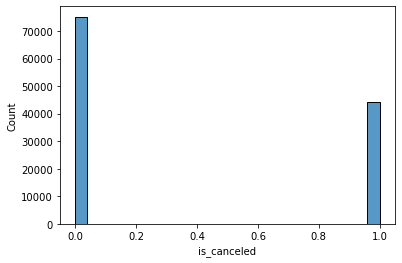

In [146]:
sns.histplot(data=df,x='is_canceled')  # Imbalanced data set

C:\Users\psupr\AppData\Local\Temp\ipykernel_12544\3126656317.py:4: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



<AxesSubplot:title={'center':'Top 10 Countries'}>

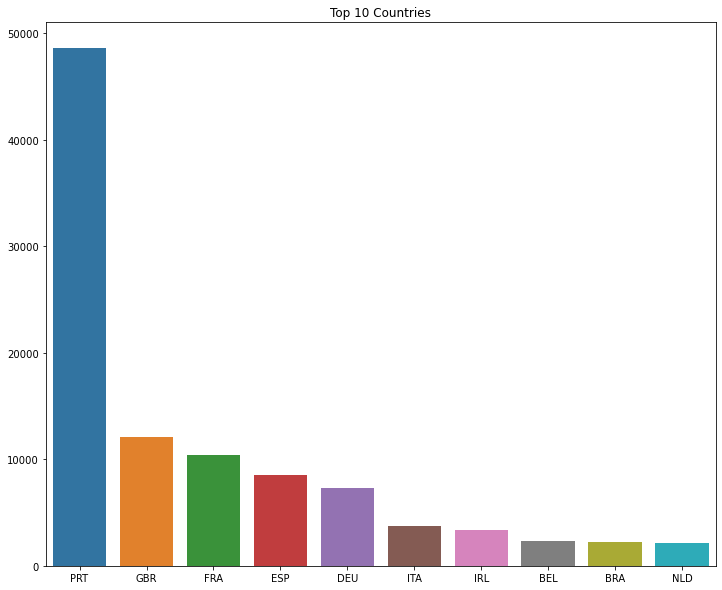

In [147]:
# Which top 10 countries have the highest booking?
fig, ax = plt.subplots(figsize = (12,10))
ax.set_title('Top 10 Countries')
fig.show()
top_ten = df.country.value_counts()[0:10]
# cleaned = clean_country(top_ten.reset_index(),'index')[['country','index_clean']]
sns.barplot(x=top_ten.index, y=top_ten.values)

In [148]:
#visualize the guests based on country - GeoMap
country_wise_guests = df[df['is_canceled'] == 0]['country'].value_counts().reset_index()
country_wise_guests.columns = ['country', 'No of guests']
basemap = folium.Map()
guests_map = px.choropleth(country_wise_guests, locations = country_wise_guests['country'],
                           color = country_wise_guests['No of guests'], hover_name = country_wise_guests['country'],
                 color_continuous_scale=px.colors.sequential.speed )
guests_map.show()

> **Initial Cleanup:** <br>
> *Summary*<br>
>>- Dropping company column as it has more nulls than any other predictors.
>>- Imputed median values for the agent and country
>>- The visulizations help us in knowing our customers came from which country ( Top 10)
>>- Cleaned up all the null values

>[Go to Data Prep Index](#data-prep)

> <h3 style="color:MediumSeaGreen;"> Outlier Detection & Treatment </h3> <a class="anchor" id="outliers-treatment"></a>

In [149]:
DataTypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_temp = df.select_dtypes(include=DataTypes)


df_temp.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.00,0.37,0.48,0.00,0.00,0.00,1.00,1.00
lead_time,119390.00,104.01,106.86,0.00,18.00,69.00,160.00,737.00
arrival_date_year,119390.00,2016.16,0.71,2015.00,2016.00,2016.00,2017.00,2017.00
arrival_date_week_number,119390.00,27.17,13.61,1.00,16.00,28.00,38.00,53.00
arrival_date_day_of_month,119390.00,15.80,8.78,1.00,8.00,16.00,23.00,31.00
stays_in_weekend_nights,119390.00,0.93,1.00,0.00,0.00,1.00,2.00,19.00
stays_in_week_nights,119390.00,2.50,1.91,0.00,1.00,2.00,3.00,50.00
adults,119390.00,1.86,0.58,0.00,2.00,2.00,2.00,55.00
children,119390.00,0.10,0.40,0.00,0.00,0.00,0.00,10.00
babies,119390.00,0.01,0.10,0.00,0.00,0.00,0.00,10.00


<AxesSubplot:>

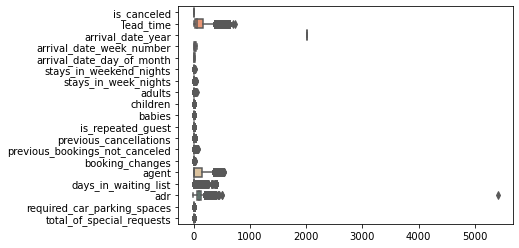

In [150]:
sns.boxplot(data=df,orient='h',palette='Set2')

> **Outlier Detection: Summary of Actions**<br>
<br>
>**Note:**<br>
    >- There was one outlier found in this data - total of special requests ( will keep this - revisit again)
    >- Clearly there is a class imbalance problem as there is more number of 0's than 1's.  Possible solution would be to do undersampling or oversampling -Will do undersampling in the later stages.

>[Go to Data Prep Index](#data-prep)

> <h3 style="color:MediumSeaGreen;"> Feature Selection</h3> <a class="anchor" id="feature-selection"></a>

In [151]:
df.select_dtypes(include=DataTypes).corr().round(3)

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
is_canceled,1.00,0.29,0.02,0.01,-0.01,-0.00,0.03,0.06,0.01,-0.03,-0.09,0.11,-0.06,-0.14,-0.05,0.05,0.05,-0.20,-0.23
lead_time,0.29,1.00,0.04,0.13,0.00,0.09,0.17,0.12,-0.04,-0.02,-0.12,0.09,-0.07,0.00,-0.02,0.17,-0.06,-0.12,-0.10
arrival_date_year,0.02,0.04,1.00,-0.54,-0.00,0.02,0.03,0.03,0.06,-0.01,0.01,-0.12,0.03,0.03,0.06,-0.06,0.20,-0.01,0.11
arrival_date_week_number,0.01,0.13,-0.54,1.00,0.07,0.02,0.02,0.03,0.01,0.01,-0.03,0.04,-0.02,0.01,-0.02,0.02,0.08,0.00,0.03
arrival_date_day_of_month,-0.01,0.00,-0.00,0.07,1.00,-0.02,-0.03,-0.00,0.01,-0.00,-0.01,-0.03,-0.00,0.01,0.00,0.02,0.03,0.01,0.00
stays_in_weekend_nights,-0.00,0.09,0.02,0.02,-0.02,1.00,0.50,0.09,0.05,0.02,-0.09,-0.01,-0.04,0.06,0.16,-0.05,0.05,-0.02,0.07
stays_in_week_nights,0.03,0.17,0.03,0.02,-0.03,0.50,1.00,0.09,0.04,0.02,-0.10,-0.01,-0.05,0.10,0.19,-0.00,0.07,-0.03,0.07
adults,0.06,0.12,0.03,0.03,-0.00,0.09,0.09,1.00,0.03,0.02,-0.15,-0.01,-0.11,-0.05,0.02,-0.01,0.23,0.01,0.12
children,0.01,-0.04,0.06,0.01,0.01,0.05,0.04,0.03,1.00,0.02,-0.03,-0.03,-0.02,0.05,0.05,-0.03,0.33,0.06,0.08
babies,-0.03,-0.02,-0.01,0.01,-0.00,0.02,0.02,0.02,0.02,1.00,-0.01,-0.01,-0.01,0.08,0.03,-0.01,0.03,0.04,0.10


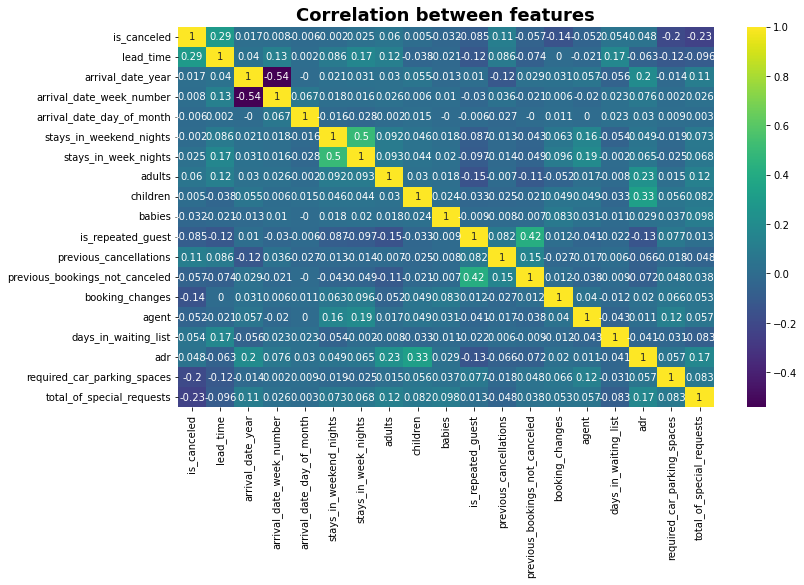

In [152]:
#Plotting heat map to visualize the correlations - More user friendly than to check with the numbers and signs.  
#I'm choosing to share this map as it makes life easier by letting us find the strong/weak correlations faster
df_corr=df.corr().round(3)
f,ax=plt.subplots(figsize=(12,7))
sns.heatmap(df_corr,cmap='viridis',annot=True)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

>**Note:**<br>
>Features with Strong/Weak Correlations :
>1. leadtime(+)
>2. previous_cancellations (+)
>3. required_car_parking_spaces	 (-)
>4. total_of_special_requests (-)
>5. booking_changes (-)

    Decisions will be made on the actual number of predictors to be included at later stages or iterations.

<br>
<br>

In [153]:
# dropping columns that are not useful

#useless_col = ['days_in_waiting_list', 'arrival_date_year', 'arrival_date_week_number', 'assigned_room_type', 'arrival_date_day_of_month',]

#df.drop(useless_col, axis = 1, inplace = True)

In [154]:
df.shape

(119390, 29)

>**Decision:**<br>
>1. Going with all the predictors available to check the performance measures.
<br><br>
>**NOTE:** <br>
   We have to keep in mind that, for classification problems - we do regularization to pick the features. Can check once again coming back


>[Go to Data Prep Index](#data-prep)

><h3>Categorical Variables</h3> </br>
    Sneak peak into the Categorical variables, making sense of it and cleaning it.

In [155]:
df.head() #making sure what is their in Data frame

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,14.00,0,Transient,0.00,0,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,14.00,0,Transient,0.00,0,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,14.00,0,Transient,75.00,0,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.00,0,Transient,75.00,0,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.00,0,Transient,98.00,0,1


In [156]:
# Create temp dataframe with target and categorical variables only
categorical = ['object']
X = pd.merge(df['is_canceled'],df.select_dtypes(include=categorical),left_index=True,right_index=True)

X.head()

,is_canceled,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type
0,0,Resort Hotel,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient
1,0,Resort Hotel,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient
2,0,Resort Hotel,July,BB,GBR,Direct,Direct,A,C,No Deposit,Transient
3,0,Resort Hotel,July,BB,GBR,Corporate,Corporate,A,A,No Deposit,Transient
4,0,Resort Hotel,July,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient


In [157]:
X.shape 

(119390, 11)

> **Feature Selection:** <br>
> *Summary*<br>
>>- Keeping all the Categorical predictor variables as most of it are related logically and makes sense. <br>


>[Go to Data Prep Index](#data-prep)

> <h3 style="color:MediumSeaGreen;"> Feature Transformation</h3> <a class="anchor" id="feature-transformations"></a>

In [158]:
# Flag categorical variables and convert to dummies
cat_vars = ['hotel','arrival_date_month','meal',
            'market_segment','distribution_channel','reserved_room_type','deposit_type','customer_type','country','assigned_room_type']

# Loop over categorical vars and encode each one
for var in cat_vars:
    df[var] = df[var].astype("category")

df = pd.get_dummies(df,columns=cat_vars, prefix_sep='_', drop_first=True)

In [159]:
df

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,hotel_Resort Hotel,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,country_ABW,country_AGO,country_AIA,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BHS,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_COM,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DJI,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FJI,country_FRA,country_FRO,country_GAB,country_GBR,country_GEO,country_GGY,country_GHA,country_GIB,country_GLP,country_GNB,country_GRC,country_GTM,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KIR,country_KNA,country_KOR,country_KWT,country_LAO,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDG,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MRT,country_MUS,country_MWI,country_MYS,country_MYT,country_NAM,country_NCL,country_NGA,country_NIC,country_NLD,country_NOR,country_NPL,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SDN,country_SEN,country_SGP,country_SLE,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_TGO,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_UMI,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P
0,0,342,2015,27,1,0,0,2,0.00,0,0,0,0,3,14.00,0,0.00,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

> **Feature Transformation:** <br>
> *Summary*<br>

>>- Categorical and Target variables encoded successfully <br>
>>- The first category for each categorical var was dropped with the 'drop_first=True' <br>



>[Go to Data Prep Index](#data-prep)

> <h3 style="color:MediumSeaGreen;"> Data Partition - TTS </h3> <a class="anchor" id="data-split"></a>

>- 1. Encompassing all the predictor variables into a variable X  <br>
>- 2. Encompassing the target variable to variable Y<br>
>- 3. Split the Training and Test Data by 70/30 with random state- 0<br>

In [160]:
target = ['is_canceled']

X = df.drop(target,axis=1)
y = df[target]

# define the undersampling method
undersample = NearMiss(version=1, n_neighbors_ver3=3)
# transform the dataset
X, y = undersample.fit_resample(X, y)

# Split data
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,random_state=1)

**Undersampling ( For correcting the imbalanced dataset)**

Of the multiple undersampling methods available, I'm using the Near Miss undersampling methods. There are 3 sub-types available within it: Near Miss-1, Near Miss-2, Near Miss-3.

>- NearMiss-1: Majority class examples with minimum average distance to three closest minority class examples.
>- NearMiss-2: Majority class examples with minimum average distance to three furthest minority class examples.
>- NearMiss-3: Majority class examples with minimum distance to each minority class example.

I'm choosing the NearMiss-1 method here as it yielded the best results after trying all 3

In [161]:
#To check how the data has been split
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(61913, 247)
(61913, 1)
(26535, 247)
(26535, 1)


array([[<AxesSubplot:title={'center':'is_canceled'}>]], dtype=object)

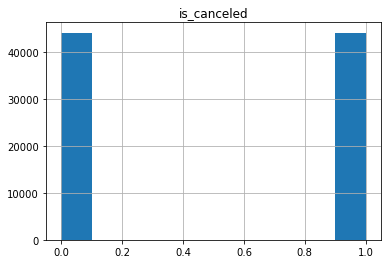

In [162]:
y.hist() #The Imbalanced data set is now in balanced state

>[Go to Data Prep Index](#data-prep)

> <h3 style="color:MediumSeaGreen;"> Data Normalization </h3> <a class="anchor" id="data-norm"></a>

In [163]:
# Normalizing the predictor variables using Z-Scores method.
# Use means and standard deviations of features as calculated in the TRAINING DATA
# New values are centered at 0.  Values reflect the number of standard deviations
# each record is above or below the mean.

DataTypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

features_means = X_train.select_dtypes(include=DataTypes).mean()
features_std = X_train.select_dtypes(include=DataTypes).std()

#Normalizing the Numerical variables
X_train_temp = (X_train.select_dtypes(include=DataTypes) - features_means)/features_std
X_test_temp = (X_test.select_dtypes(include=DataTypes) - features_means)/features_std

In [164]:
X_train.drop(['lead_time','arrival_date_year','arrival_date_week_number','arrival_date_day_of_month','stays_in_weekend_nights',
             'stays_in_week_nights','adults','children','babies','is_repeated_guest','previous_cancellations','previous_bookings_not_canceled',
             'booking_changes','agent','days_in_waiting_list','adr','required_car_parking_spaces','total_of_special_requests'],
             axis = 1, inplace = True)

X_test.drop(['lead_time','arrival_date_year','arrival_date_week_number','arrival_date_day_of_month','stays_in_weekend_nights',
             'stays_in_week_nights','adults','children','babies','is_repeated_guest','previous_cancellations','previous_bookings_not_canceled',
             'booking_changes','agent','days_in_waiting_list','adr','required_car_parking_spaces','total_of_special_requests'],
             axis = 1, inplace = True)

In [165]:
# Merging the normalized numerical predictors and categorical predictors
X_train = pd.merge(X_train,X_train_temp,left_index=True,right_index=True)
X_test  = pd.merge(X_test,X_test_temp,left_index=True,right_index=True)

In [166]:
#To check how the data has been split
print(X_train.shape)
print(X_test.shape)

(61913, 247)
(26535, 247)


>**NOTE:**:
 Always do Data Normalization for KNN as it is sensitive to the scaling of the data. It's always a good idea to do it when this model is involved.

>[Go to Data Prep Index](#data-prep)

<h1 style="background-color:powderblue; ">6. Machine Learning </h1> <a class="anchor" id="ml-model"></a>

- [X] [kNN classifier](#first-model)
- [X] [Logistic Regression](#second-model)
- [X] [Decision Tree](#third-model)
- [X] [Random Forest](#fourth-model)
- [X] [XGBoost](#fifth-model)
- [X] [Adaboost ](#sixth-model)
- [X] [Gradient Boost](#seventh-model)
- [X] [Voting Classifier](#eight-model)
- [X] [Artificial Neural Network](#ninth-model)
- [ ] [Performance Evaluation](#perf-eval)


* [Go to Top](#table-of-content)

> **KNN classifer** <a class="anchor" id="first-model"></a>
<br>
>Info:<br>

>- Finds the nearest neighour and assigns the new record to the variable with the most votes  
>- Pick an odd number for KNN as there would be no ambiguity during voting 
>- Evaluate using accuracy

In [167]:
# 1. Looping through different values of K to find optimal value of K
results = []
for k in [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train.values.ravel())
    
    # Get predicted class
    y_pred_class = knn.predict(X_test)
    
    # Put Accuracy Score in results object
    results.append({'k':k,
                    'accuracy':metrics.accuracy_score(y_test,y_pred_class)
                   }
                  )
# Put results from above into a Pandas Dataframe
results_df = pd.DataFrame(results)
results_df

,k,accuracy
0,1,0.82
1,3,0.82
2,5,0.82
3,7,0.82
4,9,0.82
5,11,0.82
6,13,0.82
7,15,0.82
8,17,0.82
9,19,0.82


>**Decision:**<br>
Based on the results above, I will set my number of neighbors (k) to 5 (also decided based on the data set size) as this achieves the highest accuracy value, even though for some values of K we are getting the same value<br>

>**Re-run kNN using the value selected above:**<br>
For this final run of kNN, we will produce a table of performance measures across a range of probability threshold values

In [168]:
start_time = time.time()

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train.values.ravel())

# Let's do a quick check to see if we have to worry about problems of overfitting.
# Remember!  Small values for "k" in kNN tend to lead to overfitting.
# Large value for "k" in kNN tend to produce underfit models
y_train_pred_class = knn.predict(X_train)
y_test_pred_class = knn.predict(X_test)

print('Training data Accuracy:', metrics.accuracy_score(y_train,y_train_pred_class).round(2))
print('Testing data Accuracy:', metrics.accuracy_score(y_test,y_test_pred_class).round(2))

acc_knn = metrics.accuracy_score(y_test,y_test_pred_class).round(2)
knntime = (time.time()-start_time)
print('Time taken for completion in sec:', knntime)

Training data Accuracy: 0.88
Testing data Accuracy: 0.82
Time taken for completion in sec: 66.07488226890564


**Observations** :
Based on the testing and training accuracy - it is quite evident in capturing most of our data and predicting well. The time taken to complete the run is about **1 min 6 seconds**

> **LOGISTIC REGRESSION (Logit Model)** <a class="anchor" id="second-model"></a>
<br>
Info: <br>

>- Uses the logit function to develop a model. Its output is the probability of that event which is converted to '1' or '0' by setting a probability threshold
>- Running the same data with logit model to compare the performance


In [169]:
start_time = time.time()

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train,y_train.values.ravel())

#predicting the values with the trained model
y_train_pred_class = lr_model.predict(X_train)
y_test_pred_class = lr_model.predict(X_test)

print('Training data Accuracy:', metrics.accuracy_score(y_train,y_train_pred_class).round(2))
print('Testing data Accuracy:', metrics.accuracy_score(y_test,y_test_pred_class).round(2))

acc_lr = metrics.accuracy_score(y_test,y_test_pred_class).round(2)
lrtime = (time.time()-start_time)
print('Time taken for completion in sec:', lrtime)

Training data Accuracy: 0.81
Testing data Accuracy: 0.81
Time taken for completion in sec: 6.328182220458984


**Observations** :
The logisitic regression gives an accuracy of 80%, which is worse than knn but, the time taken to complete the run is about ** 6 seconds** which is better than knn's time.

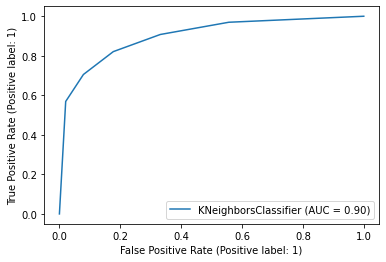

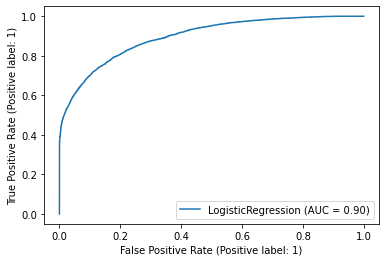

In [170]:
# ROC curve for kNN
metrics.RocCurveDisplay.from_estimator(knn,X_test,y_test)
plt.show()

# ROC curve for Logistic Model
metrics.RocCurveDisplay.from_estimator(lr_model,X_test,y_test)
plt.show()

>**Decision Point:**<br>
AUC is the same for both the models. There is just a 1% difference in accuracy of both the models, I interchangebly tried both the models to check for performance.

> **DECISION TREE** <a class="anchor" id="third-model"></a>
<br>
Info:<br>

>- Recursive splitting of data to arrive at classification assignments.
>- No need of feature selection as the algorithm by its nature does it.
>- It can handle both numerical and categorical data
>- Running the same data with Decision Tree
>- Doing Hyperparameter tuning to increase the accuracy of training and test


In [171]:
# # Hyperparameter tuning to select the best model configuration

# start_time = time.time() ## To check how long the tuning runs for, start of time
# grid = {
#     'max_depth': [15,20,25,30,40,50],
#  'min_samples_leaf': [2,4,6,8,10,12],
#  'min_samples_split': [5,10,12,14],
#  "criterion": ["gini", "entropy"]
# }

# dt_class = DecisionTreeClassifier()

# hp_tuning = GridSearchCV(estimator = dt_class, param_grid = grid, cv = 10) ## to try optimising for 'f1', 'roc_auc', 'balanced_accuracy','recall'

# hp_tuning.fit(X_train, y_train)

# best_params_dict = hp_tuning.best_params_

# print(time.time()-start_time) ## To check how long the tuning runs for, end of time
# print(best_params_dict)

**NOTE:**<br>
As it took a lot of time in Jupyter notebook to run the gridsearch, I used Google collabortory as it uses google system resources to compute. The below snapshot shows it ran for 1 hour and 10minutes to give the best parameters. 

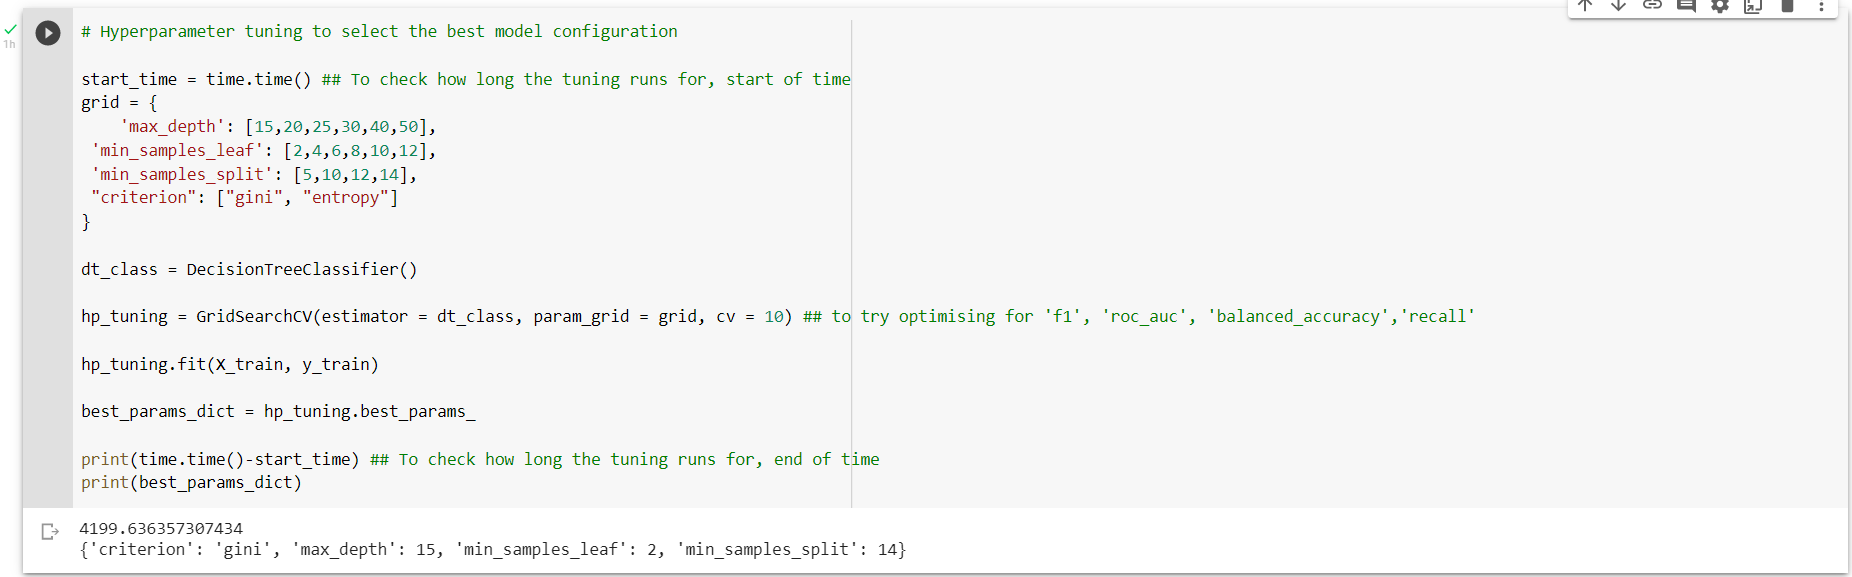

In [172]:
start_time = time.time()

dtc = DecisionTreeClassifier(criterion= 'gini',min_samples_leaf= 2,min_samples_split= 14, random_state=42,max_depth=15)
dtc.fit(X_train, y_train)

#predicting the values with the trained model
y_train_pred_class = dtc.predict(X_train)
y_test_pred_class = dtc.predict(X_test)


print('Training data Accuracy:', metrics.accuracy_score(y_train,y_train_pred_class).round(2))
print('Testing data Accuracy:', metrics.accuracy_score(y_test,y_test_pred_class).round(2))

acc_dtc = metrics.accuracy_score(y_test,y_test_pred_class).round(2)
dtctime = (time.time()-start_time)
print('Time taken for completion in sec:', dtctime)

Training data Accuracy: 0.87
Testing data Accuracy: 0.85
Time taken for completion in sec: 1.3658781051635742


**Observations** :
The Decision tree gives an accuracy of 85%, which is better than the other 2 models. But the time taken to complete the run is about **1.36 seconds** which is better than the other 2 models.

> **RANDOM FOREST** <a class="anchor" id="fourth-model"></a>
<br>
Info: <br>

>- Random forest is an ensemble method learning for classification and regression.
>- We create bootstrapped data ( many) with random number of features picked in each trial and a decision tree is built for each bootstrapped data set.
>- Running the same data with Random forest
>- Selecting parameters based on the decision tree parameters with some values tried out by trial and error

In [173]:
start_time = time.time()

rf = RandomForestClassifier(n_estimators=100, max_depth=20, max_features=25, random_state=0)
rf.fit(X_train, y_train.values.ravel())

#predicting the values with the trained model
y_train_pred_class = rf.predict(X_train)
y_test_pred_class = rf.predict(X_test)


print('Training data Accuracy:', metrics.accuracy_score(y_train,y_train_pred_class).round(2))
print('Testing data Accuracy:', metrics.accuracy_score(y_test,y_test_pred_class).round(2))


acc_rf = metrics.accuracy_score(y_test,y_test_pred_class).round(2)
rftime = (time.time()-start_time)
print('Time taken for completion in sec:', rftime)

Training data Accuracy: 0.91
Testing data Accuracy: 0.87
Time taken for completion in sec: 17.707245111465454


In [174]:
rf.get_params() # to investiagte the parameters RF has used to compute

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 25,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [175]:
importances = rf.feature_importances_ #To check which features were given more importance
forest_importances = pd.Series(importances, index=X.columns)
forest_importances.sort_values(ascending=False)

country_UZB             0.13
assigned_room_type_P    0.10
market_segment_Direct   0.10
country_MYS             0.09
assigned_room_type_H    0.06
                        ... 
country_HRV             0.00
country_HND             0.00
country_PLW             0.00
country_EST             0.00
country_IRQ             0.00
Length: 247, dtype: float64

**Observations** :
Random Forest gives an accuracy of 87%, which is better than the rest of the models. But the time taken to complete the run is about **17 seconds**.

> **XGBoost** <a class="anchor" id="fifth-model"></a>
<br>

>- One of the most powerful ensemble used today. Its name is extreme gradient boosting which does feature selection, clever penalization of trees and randomization.
>- Running the same data with XGBoost
>- Performing hyperparameter tuning to find the best parameters.

In [176]:
# start_time = time.time()

# grid = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
#  "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
#  "min_child_weight" : [ 1, 3, 5, 7 ] }

# xg_class = XGBClassifier()

# hp_tuning = RandomizedSearchCV(estimator = xg_class, param_distributions = grid, n_iter = 100)

# hp_tuning.fit(X_train, y_train)

# best_params_dict = hp_tuning.best_params_

# print(time.time()-start_time)

**NOTE:**<br>
In a similar way as the decision tree hyperparameters were deduced, the hyperparameters for XGBOOST was also done. It took around **2 days** for the tuning. I'm aware of the fact that I have a lot of predictors, which I have chosen to feed. I wanted to experiment and hence following the same strategy.

In [178]:
start_time = time.time()

xgb = XGBClassifier(learning_rate = 0.3, max_depth = 8, colsample_bytree=0.4, min_child_weight=1 )

xgb.fit(X_train, y_train)

#predicting the values with the trained model
y_train_pred_class = xgb.predict(X_train)
y_test_pred_class = xgb.predict(X_test)


print('Training data Accuracy:', metrics.accuracy_score(y_train,y_train_pred_class).round(2))
print('Testing data Accuracy:', metrics.accuracy_score(y_test,y_test_pred_class).round(2))

acc_xgb = metrics.accuracy_score(y_test,y_test_pred_class).round(2)
xgbtime = (time.time()-start_time)
print('Time taken for completion in sec:', xgbtime)

Training data Accuracy: 0.91
Testing data Accuracy: 0.88
Time taken for completion in sec: 11.399851083755493


In [179]:
xgb.get_xgb_params() #Investigating the parameteres used by the algorithm

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.4,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'interaction_constraints': '',
 'learning_rate': 0.3,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 8,
 'max_leaves': 0,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

**Observations** :
XGBoost gives an accuracy of 88%, which is better than the rest of the models. But the time taken to complete the run is about **11 seconds**.

> **Adaboost** <a class="anchor" id="sixth-model"></a>
<br>

>- AdaBoost is an ensemble learning method (also known as “meta-learning”) which was initially created to increase the efficiency of binary classifiers. AdaBoost uses an iterative approach to learn from the mistakes of weak classifiers, and turn them into strong ones
>- They create stumps (one node and two leaves) and they use a forest of stumps while giving different weights in each iteration.
>- Running the same data with Adaboost

In [180]:
start_time = time.time()

ada = AdaBoostClassifier()

ada.fit(X_train, y_train.values.ravel())

#predicting the values with the trained model
y_train_pred_class = ada.predict(X_train)
y_test_pred_class = ada.predict(X_test)


print('Training data Accuracy:', metrics.accuracy_score(y_train,y_train_pred_class).round(2))
print('Testing data Accuracy:', metrics.accuracy_score(y_test,y_test_pred_class).round(2))

acc_ada = metrics.accuracy_score(y_test,y_test_pred_class).round(2)
adatime = (time.time()-start_time)
print('Time taken for completion in sec:', adatime)

Training data Accuracy: 0.81
Testing data Accuracy: 0.81
Time taken for completion in sec: 16.860673427581787


**Observations** :
XGBoost gives an accuracy of 81% and the time taken to complete the run is about **16 seconds**.

> **Gradient Boost** <a class="anchor" id="seventh-model"></a>
<br>

>- Gradient boost gives a prediction model in the form of an ensemble of weak prediction models, which are typically decision trees. When a decision tree is the weak learner, the resulting algorithm is called gradient-boosted trees.
>- Running the same data with GradientBoost

In [181]:
start_time = time.time()

gb = GradientBoostingClassifier()

gb.fit(X_train, y_train.values.ravel())

#predicting the values with the trained model
y_train_pred_class = gb.predict(X_train)
y_test_pred_class = gb.predict(X_test)


print('Training data Accuracy:', metrics.accuracy_score(y_train,y_train_pred_class).round(2))
print('Testing data Accuracy:', metrics.accuracy_score(y_test,y_test_pred_class).round(2))

acc_gb = metrics.accuracy_score(y_test,y_test_pred_class).round(2)
gbtime = (time.time()-start_time)
print('Time taken for completion in sec:', gbtime)

Training data Accuracy: 0.84
Testing data Accuracy: 0.83
Time taken for completion in sec: 39.73342275619507


**Observations** :
Gradient Boost gives an accuracy of 83% and the time taken to complete the run is about **39 seconds**.

> **Voting classifier** <a class="anchor" id="eight-model"></a>
<br>

>- A voting classifier is a machine learning estimator that trains various base models or estimators and predicts on the basis of aggregating the findings of each base estimator. The aggregating criteria can be combined decision of voting for each estimator output.
>- Running the same data with Ensemble - Voting Classifier

In [182]:
start_time = time.time()

classifiers = [('Gradient Boosting Classifier', gb), ('XGboost', xgb),  ('Decision Tree', dtc),
                 ('Random Forest', rf), ('Ada Boost', ada), ('Logistic', lr_model),
               ('Knn', knn)]
vc = VotingClassifier(estimators = classifiers)
vc.fit(X_train, y_train.values.ravel())

#predicting the values with the trained model
y_train_pred_class = vc.predict(X_train)
y_test_pred_class = vc.predict(X_test)


print('Training data Accuracy:', metrics.accuracy_score(y_train,y_train_pred_class).round(2))
print('Testing data Accuracy:', metrics.accuracy_score(y_test,y_test_pred_class).round(2))

acc_vc = metrics.accuracy_score(y_test,y_test_pred_class).round(2)
vctime = (time.time()-start_time)
print('Time taken for completion in sec:', vctime)

Training data Accuracy: 0.88
Testing data Accuracy: 0.86
Time taken for completion in sec: 183.70003843307495


**Observations** :
Voting Classifier gives an accuracy of 86% and the time taken to complete the run is about **3 minutes**.

> **Artificial Neural Network** <a class="anchor" id="ninth-model"></a>
<br>

>- An ANN is based on a collection of connected units or nodes called artificial neurons, which loosely model the neurons in a biological brain. The synapses carry a weight when it goes through each neuron.
>- It consits of inputs, hidden layers and outputs.  We can define the number of hidden layers, as the number goes up - the complexity also goes up.
>- The building blocks of a neural network is the  activation functions. By combining many of these pieces together – flipping them, stretching them, etc.,we can create all kinds of shapes. whatever is required to fit our data!!!
>- Running the same data with ANN - MLP(Multilayer perceptron classifier)

In [184]:
start_time = time.time()

model = MLPClassifier(hidden_layer_sizes=(20,20,20), max_iter=1000,
                      activation='relu',
                      alpha=.01
                     )

model.fit(X_train,y_train.values.ravel())

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred_prob_train = model.predict_proba(X_train)[:,1]
y_pred_class = binarize([y_pred_prob],threshold=0.5)[0]
y_pred_class_train = binarize([y_pred_prob_train],threshold=0.5)[0]
confusion_test=confusion_matrix(y_test,y_pred_class)
confusion_train=confusion_matrix(y_train,y_pred_class_train)

print('Train Accuracy: ',metrics.accuracy_score(y_train,y_pred_class_train).round(2))
print('Test Accuracy: ',metrics.accuracy_score(y_test,y_pred_class).round(2))
print('Train F1: ',metrics.f1_score(y_train,y_pred_class_train).round(2))
print('Test F1: ', metrics.f1_score(y_test,y_pred_class).round(2))

acc_ann = metrics.accuracy_score(y_test,y_test_pred_class).round(2)
MLPtime = (time.time()-start_time)
print('Time taken for completion in sec:', MLPtime)

Train Accuracy:  0.89
Test Accuracy:  0.86
Train F1:  0.89
Test F1:  0.86
Time taken for completion in sec: 633.7929139137268


**Observations** :
 >* MLP gives an accuracy of 86% and the time taken to complete the run is about **11 minutes**.
 >* I changed the hidden layers to a series of combinations and found that (20,20,20) is the best.
 >* Activation functions tried: relu,tanh,identity and logisitic --> relu is the ideal one
 >* Thresholds tried: 0.2, 0.5 and 0.8 --> 0.5 is the best

> **Performance metrics** <a class="anchor" id="perf-eval"></a>

To compare the models, I'm choosing accuracy of the test data to be the main factor in deciding the efficiency of the model.

In [186]:
models = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Decision Tree Classifier', 'Random Forest Classifier','Ada Boost Classifier',
             'Gradient Boosting Classifier', 'XgBoost', 'Voting Classifier', 'ANN'],
    'Score' : [acc_lr, acc_knn, acc_dtc, acc_rf, acc_ada, acc_gb, acc_xgb, acc_vc, acc_ann],
    'Time'  : [lrtime, knntime, dtctime, rftime, adatime, gbtime,xgbtime, vctime, MLPtime]
})

models.sort_values(by = 'Score', ascending = False)

,Model,Score,Time
6,XgBoost,0.88,11.40
3,Random Forest Classifier,0.87,17.71
7,Voting Classifier,0.86,183.70
8,ANN,0.86,633.79
2,Decision Tree Classifier,0.85,1.37
5,Gradient Boosting Classifier,0.83,39.73
1,KNN,0.82,66.07
0,Logistic Regression,0.81,6.33
4,Ada Boost Classifier,0.81,16.86


In [187]:
#Plot the graph model vs accuracy (Score)
px.bar(data_frame = models, x = 'Score', y = 'Model', color = 'Score', template = 'plotly_dark', title = 'Models Comparison')

> **Winning Model**


>- I believe that **XGBoost** is the clear winner out of all the models as it has the highest accuracy.
>- Even though the time taken to complete the run is 11 seconds, i think its a fair amount of time to go through all the data and give us an output.
>- **Decision Tree** almost comes in second place because of the time it takes to run with an accuracy of 85%.
>- One of the other reason for me to choose XGBoost is that there is still a lot of potential in improving the performance by tuning the hyperparameters even more finely. ( Will try it out and hope that my laptop doesn't crash )

<h1 style="background-color:powderblue; ">7. Conclusion </h1> <a class="anchor" id="Conclusion"></a>

* [Go to Top](#table-of-content)

> **Recommendations to the Stakeholder/Employer**

>- We see that there is a strong correlation between lead time and cancellation. As lead time goes up, the cancellation also goes up. So, we can give the option of flexi booking for customers who book in advance for above 1 month. 
We can get to know from the data the mean value for lead time is 104 days, so we would give the customer 90 days to cancel without any money loss or we cut 50% after the 90 days,if they cancel.

>- We can also see that People from all over the world are staying in these two hotels. Most guests are from Portugal and other countries in Europe. They usually rent a car to move around, hence car parking space is very essential to each guest. This can be confirmed by the data. So, I would suggest the hotel owners to increase car space or give 1 parking space as mandatory to each guest and charge extra for additional spaces.

**CONCLUSION**

>* We have gone through the data for hotel booking cancellation and have done all EDA steps with evaluation of different models.
>* I have chosen to drop only some predictors while keeping most of the predictors as I wanted to more information to be fed to my model. Also, some of the models have feature selection on their own.
>* We concluded that **XGBoost** is the winning model and to be used in deployment.
>* Recommended some strategies to solve the cancellation issue at hand